## Obtain the CHEMBL data using uniprot Ids for the CAMK2A/B/D/G

- Run the following script in the github repo `GetChemblDataforTarget.py`

- Install the rd_filters repo using `pip install .`. This is developed by Pat Walters but modified to clean the CHEMBL data of PAINS compounds 

- Run `CleanCHEMBLData.sh` to clean the CHEMBL data for 4 targets. This generates two files **-clean.csv** and **-all.csv**. Former file contains only cleaned compounds, whereas later file contains all compounds with PAINS alert information 

In [1]:
import rdkit
import sklearn
import matplotlib as mpl
from rdkit import Chem
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import glob

/Users/leela.dodda/anaconda3/envs/deepchem/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [25]:
data_dict = {f.split('_')[1]:pd.read_csv(f) for f in glob.glob('CHEMBL_CAMK2*_GT3_clean-clean.csv')}

In [26]:
for key in list(data_dict.keys()):
    data_dict[key]['Label'] = [key for i in data_dict[key].index]

In [27]:
data_dict['CAMK2G'].columns

Index(['activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value', 'SMILES', 'NAME', 'FILTER',
       'MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'Label'],
      dtype='object')

## Three kinds of data available, IC50s for inhibition, Binding constants and Ki values for inhibition

In [28]:
data_dict['CAMK2G']['type'].unique()

array(['IC50', 'Kd', 'pKi'], dtype=object)

In [29]:
res_df = pd.concat(data_dict.values())
cleaned_res_df = res_df.drop_duplicates()#(['molecule_chembl_id','target_chembl_id','type'])
print('With Duplicates %d After Deleting Duplicates %d'%(res_df.pchembl_value.count(),cleaned_res_df.pchembl_value.count()))

With Duplicates 1404 After Deleting Duplicates 1154


In [30]:
for i, df in res_df.groupby('type'):
    print(i, df.type.count())

IC50 412
Kd 193
pKi 799


In [32]:
#func_df = res_df[res_df['assay_type']=='B']
#func_df = res_df.drop_duplicates(['assay_chembl_id','target_pref_name'])
#func_df

## Verify the Quality of Data & also the number of data points

In [33]:
import seaborn as sns

Text(0.5, 1.0, 'Functional pKi Data from CHEMBL')

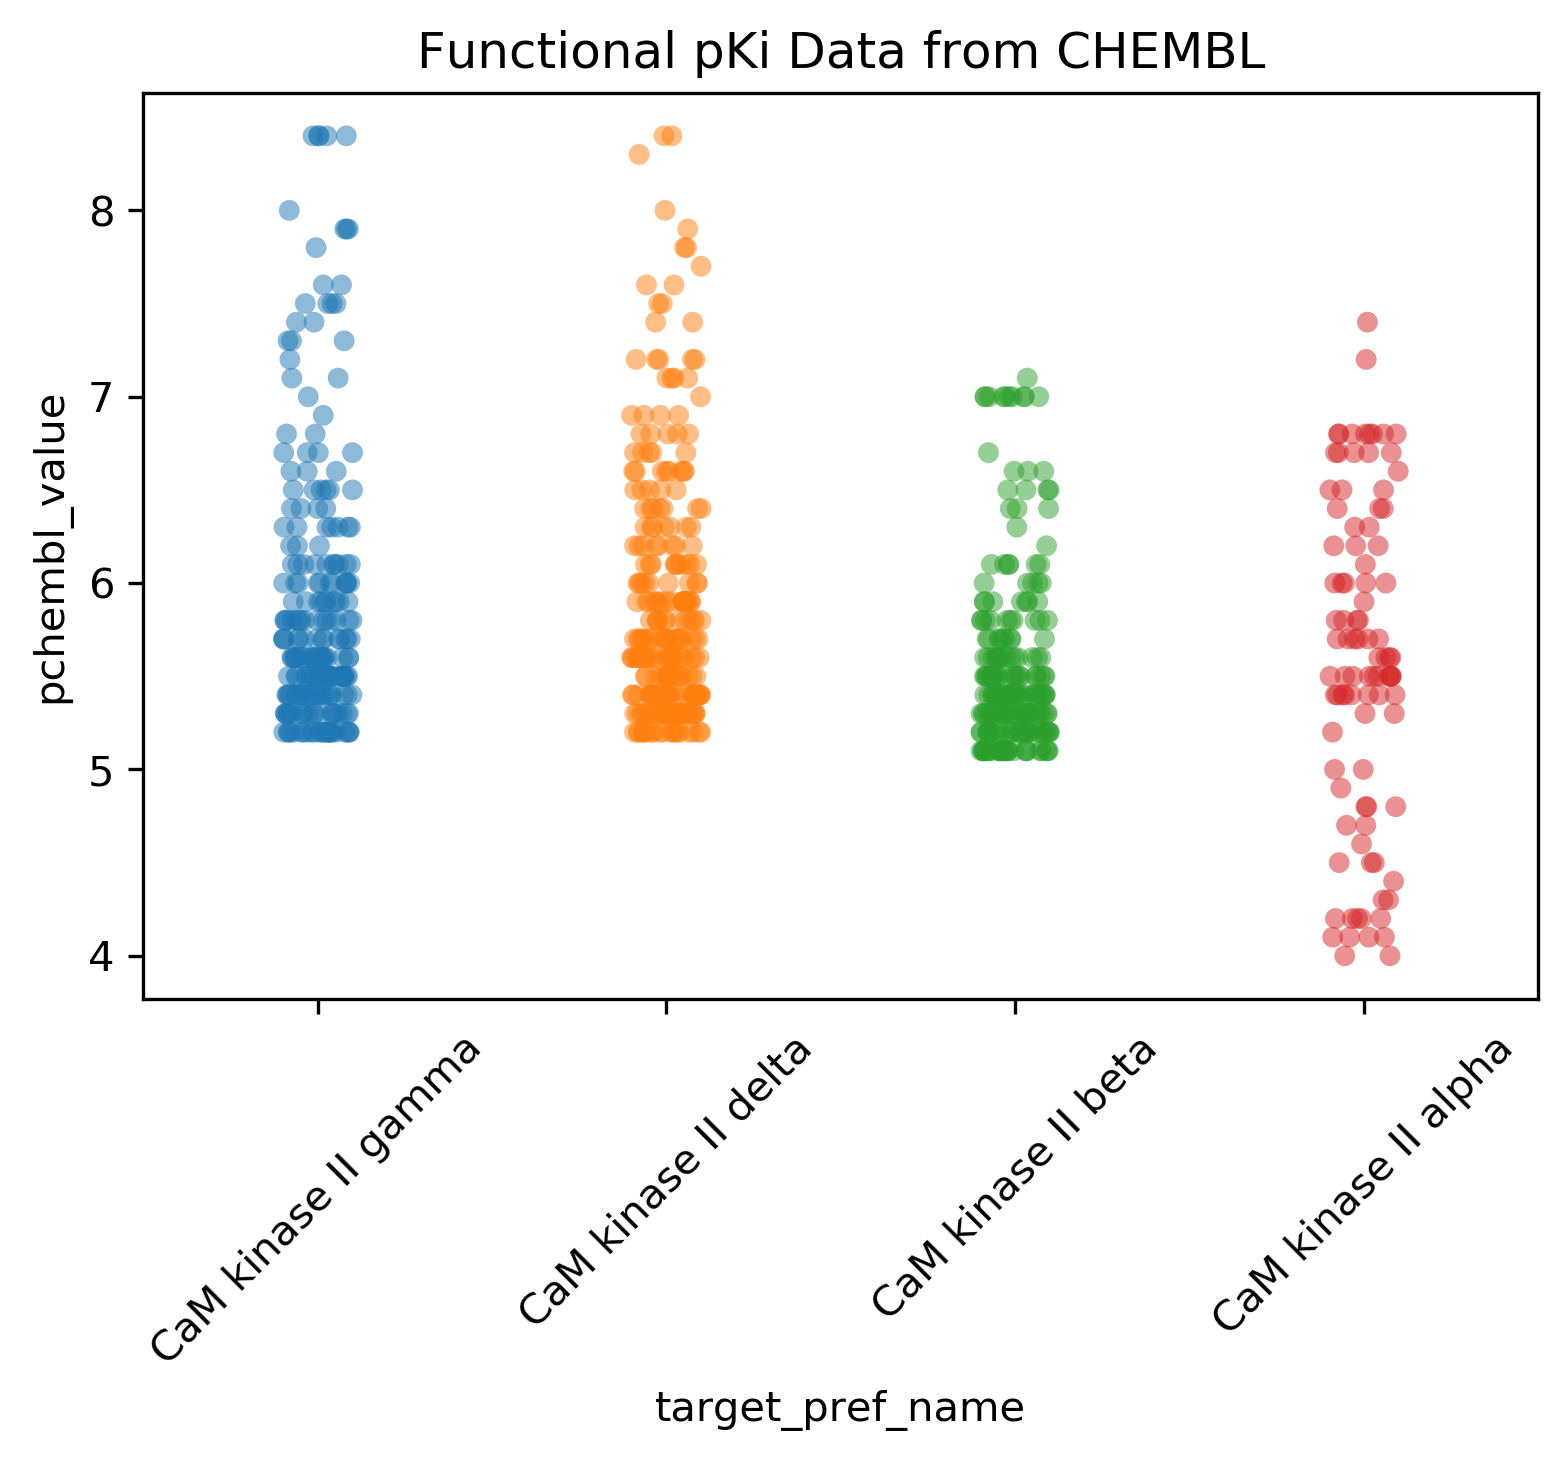

In [37]:
mpl.rcParams['figure.dpi']= 300
chart = sns.stripplot(y='pchembl_value', x='target_pref_name', 
                   data=res_df[res_df.type=='pKi'], 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
chart.set_title('Functional pKi Data from CHEMBL')

### Idea Data as there seems to be many datapoints per isoform. For LBDD models and for training ML models this can be helpful 

Text(0.5, 1.0, 'Functional pKd Data from CHEMBL')

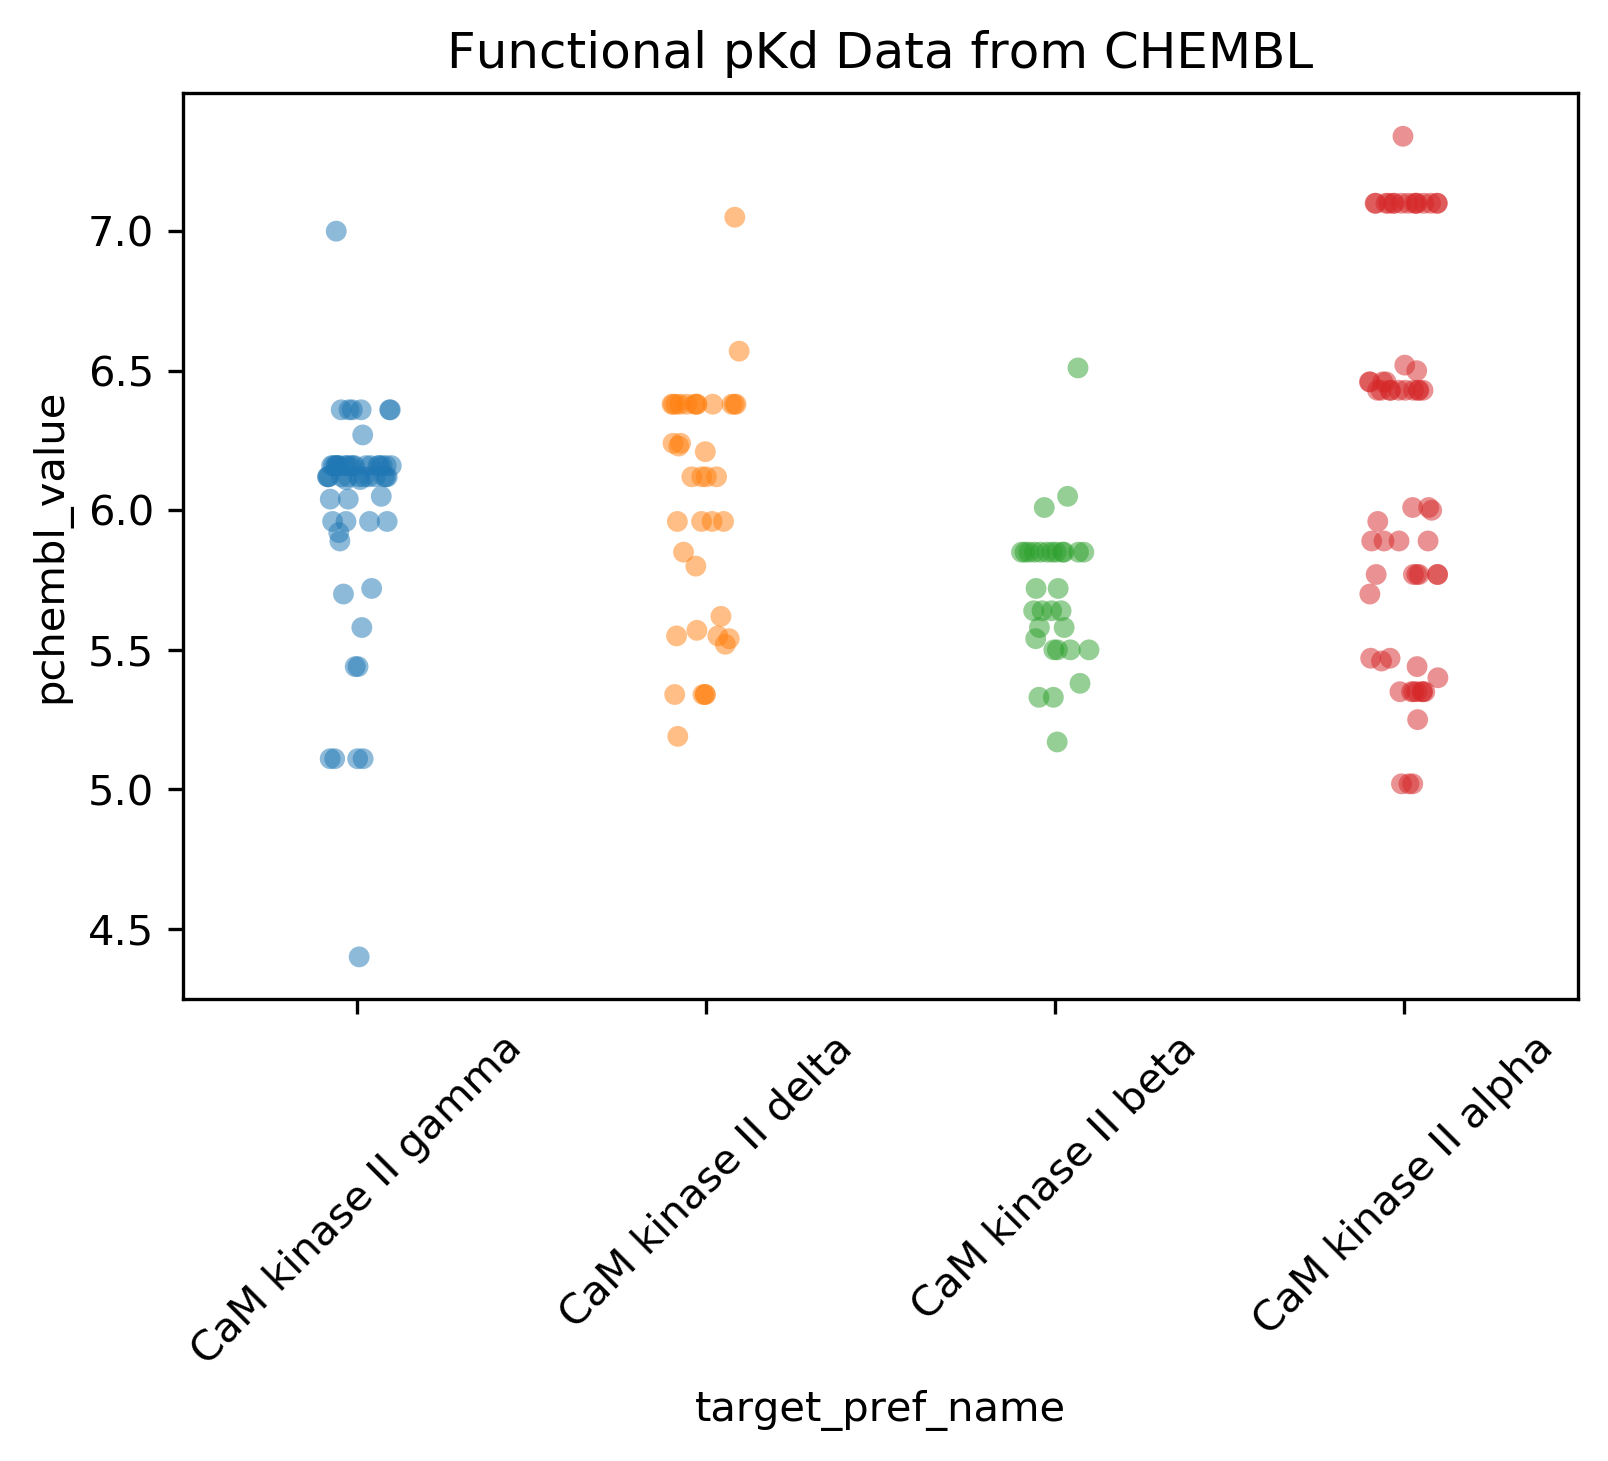

In [51]:
mpl.rcParams['figure.dpi']= 300
chart = sns.stripplot(y='pchembl_value', x='target_pref_name', 
                   data=res_df[res_df.type=='Kd'], 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
chart.set_title('Functional pKd Data from CHEMBL')

### Good amount of data, but may be too less for training ML models. But these datapoints can be used for validating structural models. When we are docking, we should verify that these ligands are ranked as-per the CHEMBL pKd data

Text(0.5, 1.0, 'Functional pIC50 Data from CHEMBL')

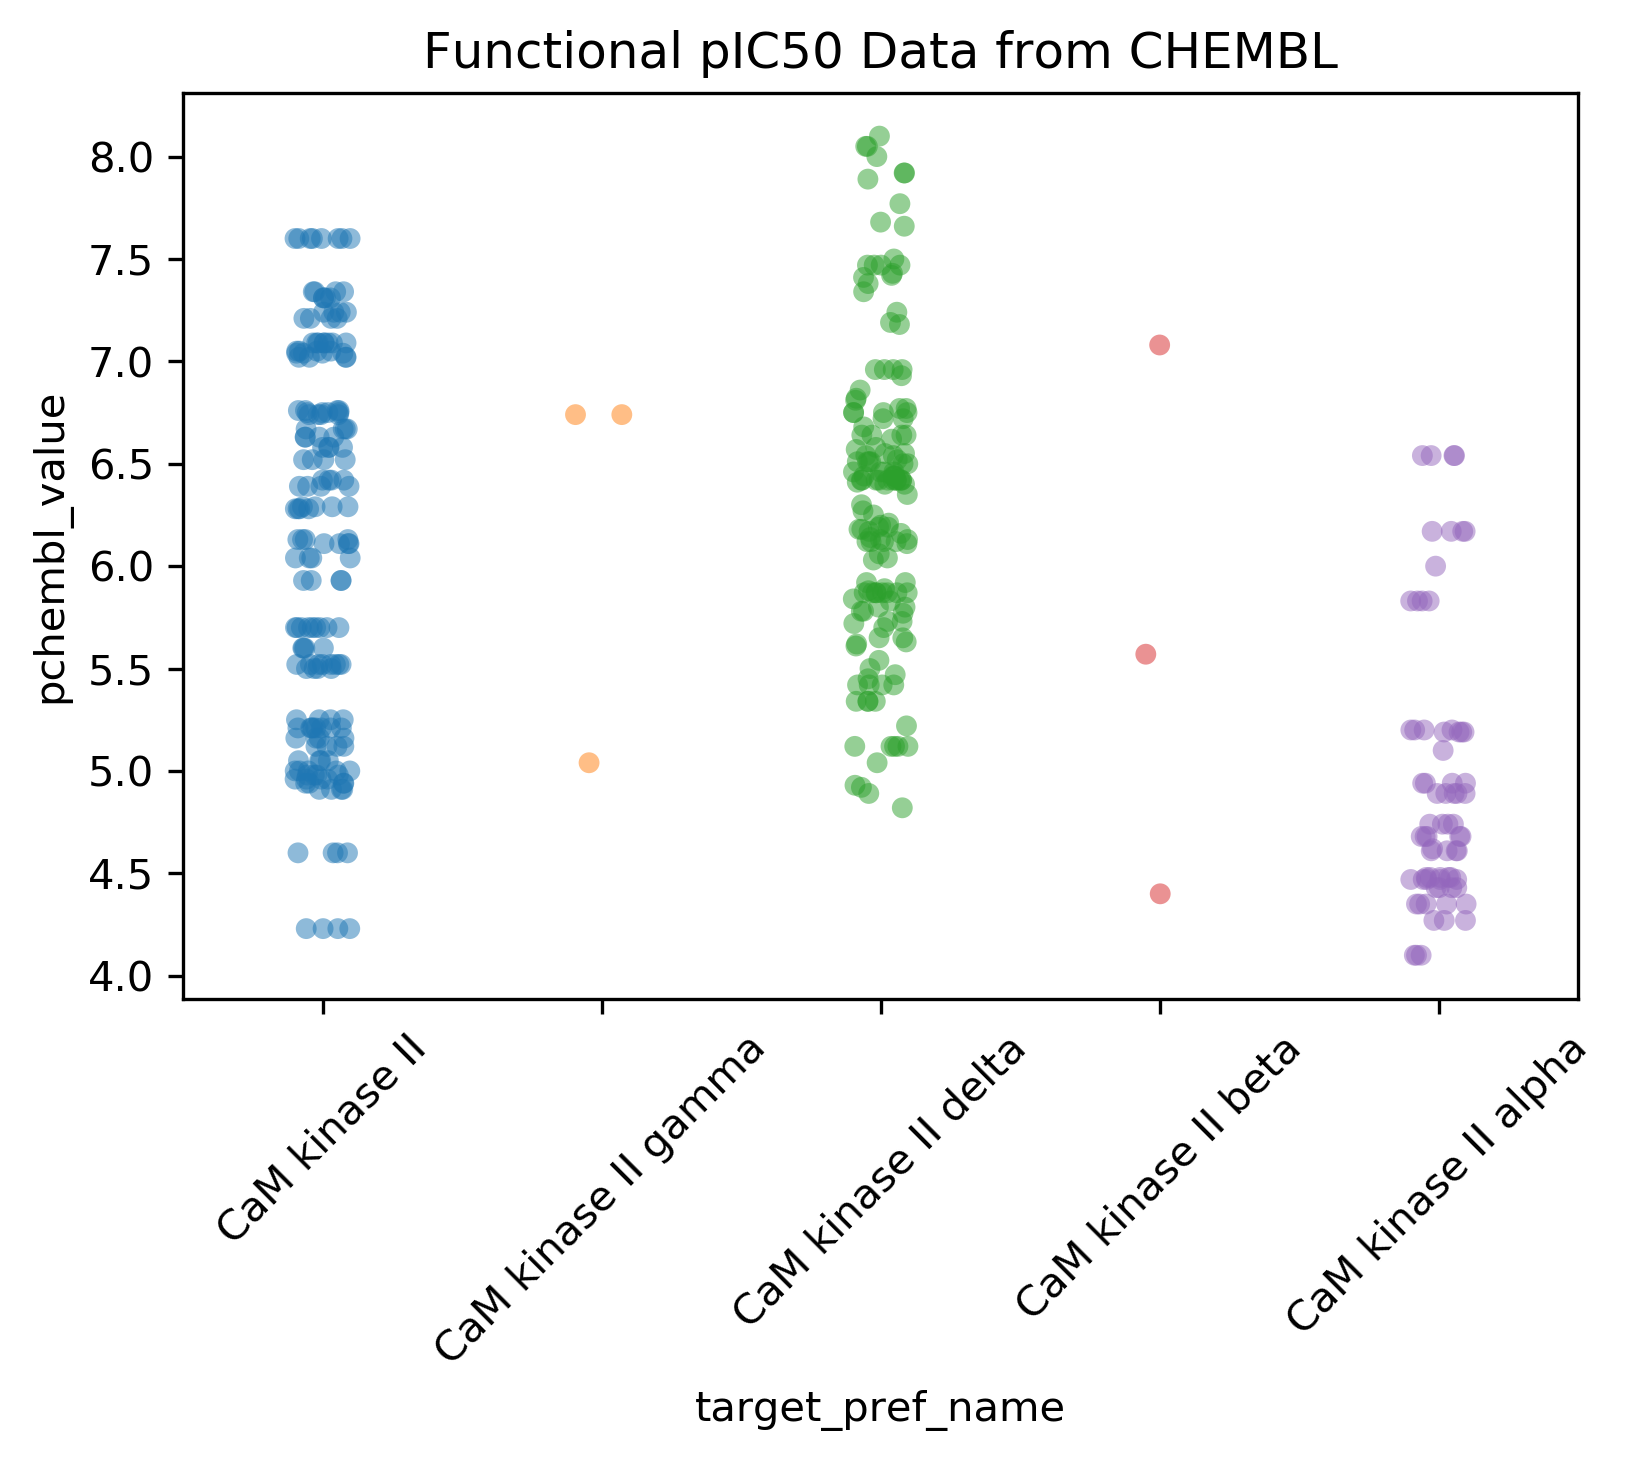

In [52]:
mpl.rcParams['figure.dpi']= 300
chart = sns.stripplot(y='pchembl_value', x='target_pref_name', 
                   data=res_df[res_df.type=='IC50'], 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
chart.set_title('Functional pIC50 Data from CHEMBL')

In [40]:
res_df['ROMol'] = [Chem.MolFromSmiles(smi) for smi in res_df.canonical_smiles]
pki_df = res_df[res_df.type=='pKi']

In [47]:
sum_= 0 
for i, df in pki_df.groupby('target_pref_name'): 
    print(i,len(df.molecule_chembl_id.unique()))
    sum_ = sum_ + len(df.molecule_chembl_id.unique())
print(sum_)

CaM kinase II alpha 85
CaM kinase II beta 193
CaM kinase II delta 238
CaM kinase II gamma 209
725


In [48]:
pki_df[pki_df['target_pref_name']=='CaM kinase II alpha']

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Label,ROMol
100,active,9511283,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,...,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,CHEMBL509032,OK,614.216,5.02410,2,10,102.93,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28f17ee0>
101,active,9511283,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,...,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,CHEMBL509032,OK,614.216,5.02410,2,10,102.93,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28f17f30>
111,active,9511278,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,NC1=NC(=O)Nc2sccc12,...,NC1=NC(=O)Nc2sccc12,CHEMBL2007097,OK,167.193,0.56680,2,4,71.77,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b2b0>
112,active,9511284,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,NC(COc1cncc(c1)c2ccc3NC(=O)C(=Cc4ccc[nH]4)c3c2...,...,NC(COc1cncc(c1)c2ccc3NC(=O)C(=Cc4ccc[nH]4)c3c2...,CHEMBL1980407,OK,436.515,4.51820,3,4,93.03,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b300>
113,active,9511291,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1ccc(cc1)n2ccc3cnc(Nc4cc(OC)c(OC)c(OC)c4)nc23,...,COc1ccc(cc1)n2ccc3cnc(Nc4cc(OC)c(OC)c(OC)c4)nc23,CHEMBL1975927,OK,406.442,4.19850,1,8,79.66,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b350>
114,active,9511292,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,...,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,CHEMBL1986943,OK,343.818,3.38870,3,5,86.72,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b3a0>
115,active,9511292,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,...,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,CHEMBL1986943,OK,343.818,3.38870,3,5,86.72,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b3f0>
116,active,9515415,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,...,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,CHEMBL1986943,OK,343.818,3.38870,3,5,86.72,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b440>
117,active,9515415,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,...,OC1CCC(CC1)Nc2nc(Cl)cc(n2)c3c[nH]c4ncccc34,CHEMBL1986943,OK,343.818,3.38870,3,5,86.72,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b490>
118,active,9511293,[],CHEMBL1964111,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,CC(Nc1cncc(n1)n2cnc3ccc(cc23)C#N)c4ccccc4F,...,CC(Nc1cncc(n1)n2cnc3ccc(cc23)C#N)c4ccccc4F,CHEMBL1977138,OK,358.380,3.99938,1,6,79.42,CAMK2A,<rdkit.Chem.rdchem.Mol object at 0x1a28e9b4e0>


In [54]:
pki_df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,...,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Label,ROMol
98,active,9508352,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,...,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,CHEMBL509032,OK,614.216,5.02410,2,10,102.93,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a28343530>
99,active,9508352,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,...,COc1cc(ccc1Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C...,CHEMBL509032,OK,614.216,5.02410,2,10,102.93,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a28343580>
105,active,9508404,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1cc(Nc2ncc(F)c(Nc3ccc4OC(C)(C)C(=O)Nc4n3)n2...,...,COc1cc(Nc2ncc(F)c(Nc3ccc4OC(C)(C)C(=O)Nc4n3)n2...,CHEMBL475251,OK,470.461,3.63320,3,10,128.75,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a28343760>
106,active,9508404,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1cc(Nc2ncc(F)c(Nc3ccc4OC(C)(C)C(=O)Nc4n3)n2...,...,COc1cc(Nc2ncc(F)c(Nc3ccc4OC(C)(C)C(=O)Nc4n3)n2...,CHEMBL475251,OK,470.461,3.63320,3,10,128.75,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a283437b0>
109,active,9508193,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,COc1cc(ccc1O)c2ccc3C(=O)Nc4cc(ccc4Nc3c2)C(=O)N...,...,COc1cc(ccc1O)c2ccc3C(=O)Nc4cc(ccc4Nc3c2)C(=O)N...,CHEMBL2000832,OK,483.499,5.44620,4,5,99.69,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a283438a0>
110,active,9508196,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,...,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,CHEMBL1965660,OK,348.193,3.12660,3,4,110.68,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a283438f0>
111,active,9508196,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,...,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,CHEMBL1965660,OK,348.193,3.12660,3,4,110.68,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a28343940>
112,active,9508299,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,...,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,CHEMBL1965660,OK,348.193,3.12660,3,4,110.68,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a28343990>
113,active,9508299,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,...,NC(=O)c1cc([nH]c1c2ccc(Cl)cc2Cl)c3ccnc(N)n3,CHEMBL1965660,OK,348.193,3.12660,3,4,110.68,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a283439e0>
114,active,9508199,[],CHEMBL1963710,PUBCHEM_BIOASSAY: Navigating the Kinome. (Clas...,F,BAO_0000192,BAO_0000019,assay format,Nc1ncnc2sc(Br)c(c3ccc(NC(=O)Cc4cccc(Cl)c4)cc3)c12,...,Nc1ncnc2sc(Br)c(c3ccc(NC(=O)Cc4cccc(Cl)c4)cc3)c12,CHEMBL1980896,OK,473.783,5.53760,2,5,80.90,CAMK2G,<rdkit.Chem.rdchem.Mol object at 0x1a28343a30>
